<a href="https://colab.research.google.com/github/parthrjpt/EAS546_Projects/blob/DEV/CSE546_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collaborators:
 *   Yonghui Lin(yonghuil@buffalo.edu )
 *   Parth Rahput(parthket@buffalo.edu)


In [ ]:
!pip install gym

In [ ]:
# widgets from google is used, please run it with colab
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from google.colab import widgets
import time
import copy
import random
from collections import deque

In [ ]:
# import torch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable


# Environment Setup

In [ ]:
class DeterEnvironment(gym.Env):
    def __init__(self):
      # agent will act on a 4x4 gridworld with 4 actions
        self.max_steps = 30
        self.action_space = spaces.Discrete(4)
        self.obs_space = spaces.Discrete(16)
        self.ate = False
        # self.encodedstate=np.array(range(0,16))
        
    def reset(self):
      # terminal state = [3, 3], positive reward state = [1, 3], negative reward state = [2, 0]
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.reward_pos1 = [1, 3]
        self.reward_pos2 = [2, 0]
        self.reward_pos3 = [2, 2]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 0.2
        # self.state[tuple(self.reward_pos1)] = 0.4
        self.state[tuple(self.reward_pos2)] = 0.6
        # self.state[tuple(self.reward_pos3)] = 0.6
        self.state[tuple(self.goal_pos)] = 1
        observation = self.agent_pos
        return observation
    
    def step(self, action):
        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 0.2
        self.state[tuple(self.reward_pos1)] = 0.4
        self.state[tuple(self.reward_pos2)] = 0.6
        # self.state[tuple(self.reward_pos3)] = 0.6
        self.state[tuple(self.goal_pos)] = 1
        observation = self.agent_pos
        
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
          reward = 10
        if (self.agent_pos == self.reward_pos1).all() and not self.ate:
          reward = 3
          self.ate = True
        if (self.agent_pos == self.reward_pos2).all():
          reward = -3
        if (self.agent_pos == self.reward_pos3).all():
          reward = -3
        
        self.timestep += 1
        done = True if (self.agent_pos == self.goal_pos).all() else False
        info = {}
        return observation, reward, done, info
        
    def render(self):
        plt.imshow(self.state)


In [ ]:
class StochasticEnvironment(gym.Env):
    def __init__(self):
      # agent will act on a 4x4 gridworld with 4 actions
        self.max_steps = 25
        self.action_space = spaces.Discrete(4)
        self.obs_space = spaces.Discrete(16)
        
    def reset(self):
      # terminal state = [3, 3], positive reward state = [1, 3], negative reward state = [2, 0]
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.reward_pos1 = [1, 3]
        self.reward_pos2 = [2, 0]
        self.reward_pos3 = [2, 2]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 0.2
        self.state[tuple(self.reward_pos1)] = 0.4
        self.state[tuple(self.reward_pos2)] = 0.6
        self.state[tuple(self.reward_pos3)] = 0.6
        self.state[tuple(self.goal_pos)] = 1
        observation = self.agent_pos
        return observation
    
    def step(self, action):
      # Agent has 0.9 probability can go to the given direction and with 0.1 probability go to a different direction
        prob = np.random.randint(10)
        if action == 0 and prob > 1:
          self.agent_pos[0] += 1
        if action == 0 and prob <=1:
          self.agent_pos[1] += 1
        if action == 1 and prob > 1:
          self.agent_pos[0] -= 1
        if action == 1 and prob <= 1:
          self.agent_pos[1] -= 1
        if action == 2 and prob > 1:
          self.agent_pos[1] += 1
        if action == 2 and prob <= 1:
          self.agent_pos[0] += 1
        if action == 3 and prob > 1:
          self.agent_pos[1] -= 1
        if action == 3 and prob <= 1:
          self.agent_pos[0] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 0.2
        self.state[tuple(self.reward_pos1)] = 0.4
        self.state[tuple(self.reward_pos2)] = 0.6
        self.state[tuple(self.reward_pos3)] = 0.6
        self.state[tuple(self.goal_pos)] = 1
        observation = self.agent_pos
        
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
          reward = 10
        if (self.agent_pos == self.reward_pos1).all():
          reward = 3
        if (self.agent_pos == self.reward_pos2).all():
          reward = -3
        if (self.agent_pos == self.reward_pos3).all():
          reward = -3
        
        self.timestep += 1
        done = True if (self.timestep >= self.max_steps) or (self.agent_pos == self.goal_pos).all() else False
        info = {}
        
        return observation, reward, done, info
        
    def render(self):
        plt.imshow(self.state)
        

# DQN

In [ ]:
class NET1(nn.Module):
    def __init__(self, ):
        super(NET1, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(32, 4)
        self.fc2.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

BATCH_SIZE = 50
MIN_BATCH_SIZE = 50
MAX_REPLAY_BUFFER_SIZE = 1200
EPSILON = 1

UPDATE = 100
GAMMA = 0.9
env = DeterEnvironment()

class DQNAgent:
    def __init__(self, env):
        self.obs_space = env.obs_space
        self.action_space = env.action_space
        self.env = env
        self.replay_mem = deque(maxlen = MAX_REPLAY_BUFFER_SIZE)
        self.model = NET1()
        self.target_model = NET1()
        self.loss_func = nn.MSELoss()
        self.optimizer = optimizer = optim.Adam(self.model.parameters())
        self.target_model.fc1.weight = self.model.fc1.weight
        self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter = 0
        

    def step(self, x):
        x = Variable(torch.unsqueeze(torch.FloatTensor(x), 0))
        if np.random.uniform() > EPSILON:
          actions = self.model(x)
          action = torch.max(actions, 1)[1].data.numpy()
          action = action[0]
          # print(actions, action)
        else:
          action = np.random.randint(4)
        return action
        
    def store_mem(self, state, action, reward, next_state, done):
      self.replay_mem.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.replay_mem) < MIN_BATCH_SIZE:
          return
        if self.learn_counter % UPDATE == 0:
          # print("----------------------update-----------------")
          # self.target_model.load_state_dict(self.model.state_dict())
          self.target_model.fc1.weight = self.model.fc1.weight
          self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter += 1
        batch = random.sample(self.replay_mem, BATCH_SIZE)
        s, a, r, s_, done = (list(col) for col in zip(*batch))


        ########working algorithm do not remove########
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r).view(BATCH_SIZE,1)
        s_ = torch.FloatTensor(s_)
        q_val = self.model(s)
        q_next = self.target_model(s_)  

        q_target = torch.tensor([q_next[i].max()*GAMMA+r[i] for i in range(BATCH_SIZE)])
        q_ = q_val[:, 0]
        for i in range(len(done)):
          q_[i] = q_val[i][a[i]]
          if done[i]:
            q_target[i] = r[i]
                    
        q_target = torch.FloatTensor(q_target)

        loss = self.loss_func(q_, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


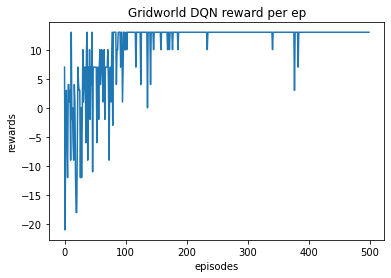

<function matplotlib.pyplot.show>

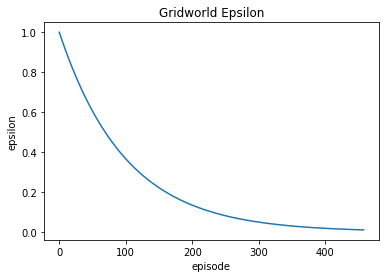

In [ ]:
# def gridDQN():
# setting up environment and agent
fv

#Double DQN

In [ ]:
BATCH_SIZE = 50
MIN_BATCH_SIZE = 50
MAX_REPLAY_BUFFER_SIZE = 1200
EPSILON = 1

UPDATE = 100
GAMMA = 0.9
env = DeterEnvironment()

class DDQNAgent:
    def __init__(self, env):
        self.obs_space = env.obs_space
        # self.encodedstate=np.array(range(0,16))
        self.action_space = env.action_space
        self.env = env
        self.replay_mem = deque(maxlen = MAX_REPLAY_BUFFER_SIZE)
        self.model = NET1()
        self.target_model = NET1()
        self.loss_func = nn.MSELoss()
        self.optimizer = optimizer = optim.Adam(self.model.parameters())
        # self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        self.target_model.fc1.weight = self.model.fc1.weight
        self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter = 0
        

    def step(self, x):
        x = Variable(torch.unsqueeze(torch.FloatTensor(x), 0))
        if np.random.uniform() > EPSILON:
          actions = self.model(x)
          action = torch.max(actions, 1)[1].data.numpy()
          action = action[0]
          # print(actions, action)
        else:
          action = np.random.randint(4)
        return action
        
    def store_mem(self, state, action, reward, next_state, done):
      self.replay_mem.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.replay_mem) < MIN_BATCH_SIZE:
          return
        if self.learn_counter % UPDATE == 0:
          # print("----------------------update-----------------")
          # self.target_model.load_state_dict(self.model.state_dict())
          self.target_model.fc1.weight = self.model.fc1.weight
          self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter += 1
        batch = random.sample(self.replay_mem, BATCH_SIZE)
        s, a, r, s_, done = (list(col) for col in zip(*batch))
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r).view(BATCH_SIZE,1)
        s_ = torch.FloatTensor(s_)
        
        q_val = self.model(s_)
        q_next = self.target_model(s_)  
        q_arg = torch.tensor([torch.argmax(q_next[i]) for i in range(BATCH_SIZE)])
        q_ = q_val[:, 0]
        for i in range(BATCH_SIZE):
          q_[i] = q_val[i][q_arg[i]]
        q_=q_.view(BATCH_SIZE,1)
        q_target = r+GAMMA*q_
        q_val = self.model(s)
        q_ = q_val[:, 0]
        for i in range(BATCH_SIZE):
          q_[i] = q_val[i][a[i]]
        q_ = q_.view(BATCH_SIZE,1)
        loss = self.loss_func(q_, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
# def  gridDDQN():
# setting up environment and agent
env = DeterEnvironment()
agent = DDQNAgent(env)

obs = env.reset()
done = False

# setting up animation
E_DECAY = 0.99
EPSILON = 1
# output_grid = widgets.Grid(4, 4)
# with output_grid.output_to(0, 0):
#   env.render()

gridDDQNplot=[]
n_games = 1000
# Double DQN Loop
for i in range(n_games):
    state = env.reset()
    encodedstate=np.array(range(0,16)).reshape(4,4)
    done = False
    cumulative_reward=0
    env.ate = False
    for k in range(env.max_steps):
      action = agent.step(env.agent_pos)
      s = np.copy(env.agent_pos)
      obs, reward, done, info = env.step(action)
      s_ = np.copy(obs)
      if k == env.max_steps-1 and not done:
        reward = -10
      agent.store_mem(s, action, reward, s_, done)
      cumulative_reward+=reward
      # trains for every 3 time steps
      if k%3 == 0:
        agent.train()
      if done: 
        break
    # EPSILON = EPSILON - 2/n_games if EPSILON > 0.01 else 0.01
    if EPSILON>=0.001:
      EPSILON*=E_DECAY
    gridDDQNplot.append(cumulative_reward)

gridDDQNgreedy = []
for i in range(5):
    state = env.reset()
    done = False
    cumulative_reward=0
    env.ate = False
    for _ in range(env.max_steps):
      action = agent.step(env.agent_pos)
      obs, reward, done, info = env.step(action)
      cumulative_reward+=reward
      if done: 
        break
    # EPSILON = EPSILON - 2/n_games if EPSILON > 0.01 else 0.01
    if EPSILON>=0.01:
      EPSILON*=E_DECAY
    gridDDQNgreedy.append(cumulative_reward)
#episodes= range(1,1000)
plt.plot(gridDDQNplot)
plt.title('Grid DDQN reward per ep')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()



# Cartpole Environment

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
import random
from collections import deque



## Cartpole DQN

In [ ]:
class NET2(nn.Module):
    def __init__(self, ):
        super(NET2, self).__init__()
        self.fc1 = nn.Linear(4, 50)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(50, 2)
        self.fc2.weight.data.normal_(0, 0.1)
        # self.fc3 = nn.Linear(30, 4)
        # self.fc3.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.relu(x)
        # x = self.fc3(x)
        return x

env = gym.make("CartPole-v1")
BATCH_SIZE = 50
MIN_BATCH_SIZE = 50
MAX_REPLAY_BUFFER_SIZE = 1200
EPSILON = 1
N_ACTIONS = env.action_space.n
N_STATES =4
UPDATE = 100
GAMMA = 0.9
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape

class CartpoleDQNAgent:
    def __init__(self, env):
        self.env = env
        self.replay_mem = np.zeros((MAX_REPLAY_BUFFER_SIZE, N_STATES * 2 + 2))
        self.model = NET2()
        self.target_model = NET2()
        self.loss_func = nn.MSELoss()
        self.optimizer = optimizer = optim.Adam(self.model.parameters())
        # self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        self.target_model.fc1.weight = self.model.fc1.weight
        self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter = 0
        self.memory_counter = 0
        

    def step(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() > EPSILON:   # greedy
            actions_value = self.model.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
        
    def store_mem(self, s, a, r, s_):
      transition = np.hstack((s, [a, r], s_))
      index = self.memory_counter % MAX_REPLAY_BUFFER_SIZE
      self.replay_mem[index, :] = transition
      self.memory_counter += 1

    def train(self):
        if len(self.replay_mem) < MIN_BATCH_SIZE:
          return
        if self.learn_counter % UPDATE == 0:
          # print("----------------------update-----------------")
          self.target_model.load_state_dict(self.model.state_dict())
        self.learn_counter += 1
        sample_index = np.random.choice(MAX_REPLAY_BUFFER_SIZE, BATCH_SIZE)
        b_memory = self.replay_mem[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.model(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_model(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

NameError: ignored

In [ ]:
# def cartPoleDQN():
env = gym.make("CartPole-v1")
BATCH_SIZE = 50
MIN_BATCH_SIZE = 50
MAX_REPLAY_BUFFER_SIZE = 1200
EPSILON = 1
N_ACTIONS = env.action_space.n
N_STATES =4
UPDATE = 100
GAMMA = 0.9
agent = CartpoleDQNAgent(env)

obs = env.reset()
done = False

# setting up animation
E_DECAY = 0.995

cartDQNplot=[]
cartepsilonplot=[]

n_games = 500
for i_episode in range(n_games):
    s = env.reset()
    ep_r = 0
    while True:
        a = agent.step(s)
        s_, r, done, info = env.step(a)
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2

        agent.store_mem(s, a, r, s_)
        ep_r += r
        if agent.memory_counter > MAX_REPLAY_BUFFER_SIZE:
            agent.train()

        if done:
            break
        s = s_
        if EPSILON > 0.01:
          EPSILON *= E_DECAY
    cartDQNplot.append(ep_r)

cartDQNgreedy = []
for i_episode in range(5):
    s = env.reset()
    ep_r = 0
    while True:
        a = agent.step(s)
        s_, r, done, info = env.step(a)
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2
        ep_r += r

        if done:
            break
        s = s_
        if EPSILON > 0.01:
          EPSILON *= E_DECAY
    cartDQNgreedy.append(ep_r)

# plt.plot(cartDQNplot)
# plt.title('cartpole DQN reward per ep')
# plt.xlabel('episodes')
# plt.ylabel('cumulativereward')
# plt.show()

## Cartpole Dueling DQN

In [ ]:
class NET2(nn.Module):
    def __init__(self, ):
        super(NET2, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.fc2 = nn.Linear(64, 2)
        self.learn_V = nn.Linear(64, 2)
        self.learn_A  = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.fc2(x)
     
        a = self.learn_A(x)
        v = self.learn_V(x)
        return v + (a - a.max(1, keepdim=True)[0])

BATCH_SIZE = 50
MIN_BATCH_SIZE = 50
MAX_REPLAY_BUFFER_SIZE = 1200
EPSILON = 1
env = gym.make("CartPole-v1")
N_ACTIONS = env.action_space.n
N_STATES=4
UPDATE = 100
GAMMA = 0.9
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape

class CartpoleDQNAgent:
    def __init__(self, env):
        self.env = env
        self.replay_mem = np.zeros((MAX_REPLAY_BUFFER_SIZE, N_STATES * 2))
        self.model = NET2()
        self.target_model = NET2()
        self.loss_func = nn.MSELoss()
        self.optimizer = optimizer = optim.Adam(self.model.parameters())
        # self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        self.target_model.fc1.weight = self.model.fc1.weight
        #self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter = 0
        self.memory_counter = 0
        

    def step(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() > EPSILON:   # greedy
            actions_value = self.model.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
        
    def store_mem(self, s, a, r, s_):
      transition = np.hstack((s, [a, r], s_))
      index = self.memory_counter % MAX_REPLAY_BUFFER_SIZE
      self.replay_mem[index, :] = transition
      self.memory_counter += 1

    def train(self):
        if len(self.replay_mem) < MIN_BATCH_SIZE:
          return
        if self.learn_counter % UPDATE == 0:
          # print("----------------------update-----------------")
          self.target_model.load_state_dict(self.model.state_dict())
          # self.target_model.fc1.weight = self.model.fc1.weight
          # self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter += 1
        # batch = random.sample(self.replay_mem, BATCH_SIZE)



        sample_index = np.random.choice(MAX_REPLAY_BUFFER_SIZE, BATCH_SIZE)
        b_memory = self.replay_mem[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.model(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_model(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
env = gym.make("CartPole-v1")
BATCH_SIZE = 50
MIN_BATCH_SIZE = 50
MAX_REPLAY_BUFFER_SIZE = 1200
EPSILON = 1
N_ACTIONS = env.action_space.n
N_STATES =4
UPDATE = 100
GAMMA = 0.9
agent = CartpoleDQNAgent(env)

obs = env.reset()
done = False

# setting up animation
E_DECAY = 0.995

cartDDQNplot=[]
cartEpsilon=[]


for i_episode in range(500):
    s = env.reset()
    ep_r = 0
    while True:
        a = agent.step(s)
        s_, r, done, info = env.step(a)
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2

        agent.store_mem(s, a, r, s_)
        ep_r += r
        if agent.memory_counter > MAX_REPLAY_BUFFER_SIZE:
            agent.train()
        if done:
            break
        s = s_
        if EPSILON > 0.01:
          EPSILON *= E_DECAY
    cartDDQNplot.append(ep_r)


cartDDQNgreedy = []
for i_episode in range(5):
    s = env.reset()
    ep_r = 0
    while True:
        a = agent.step(s)
        s_, r, done, info = env.step(a)
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2
        ep_r += r
        if done:
            break
        s = s_
        if EPSILON > 0.01:
          EPSILON *= E_DECAY
    cartDDQNgreedy.append(ep_r)

# plt.plot(cartDDQNplot)
# plt.title('cartpole Dueling reward per ep')
# plt.xlabel('episodes')
# plt.ylabel('cumulativereward')
# plt.show()

# EPSILON = 1

# while EPSILON>=0.01:
#   EPSILON*=E_DECAY
#   cartEpsilon.append(EPSILON)
  
# plt.plot(cartEpsilon)
# plt.title('cartpole epsilon')
# plt.xlabel('episode')
# plt.ylabel('epsilon')
# plt.show


#Multiagent Environment

In [ ]:
class MultiAgentEnv(gym.Env):
    def __init__(self):
      # agent will act on a 4x4 gridworld with 4 actions
        self.max_steps = 30
        self.action_space = spaces.Discrete(5)
        self.obs_space = spaces.Discrete(25)
        self.ate = False
        # self.encodedstate=np.array(range(0,16))
        
    def reset(self):
      # terminal state = [3, 3], positive reward state = [1, 3], negative reward state = [2, 0]
        self.timestep = 0
        self.agentA_pos = [0, 0]
        self.agentB_pos = [4, 4]
        self.teleIn = [4, 0]
        self.teleOut = [0, 4]
        self.state = np.zeros((5, 5))
        self.state[tuple(self.agentA_pos)] = 0.5
        self.state[tuple(self.agentB_pos)] = 1
        observation = (self.agentA_pos, self.agentB_pos)
        return observation
    
    def step(self, actionA, actionB):
        if actionA == 0:
          self.agentA_pos[0] += 1
        if actionA == 1:
          self.agentA_pos[0] -= 1
        if actionA == 2:
          self.agentA_pos[1] += 1
        if actionA == 3:
          self.agentA_pos[1] -= 1

        if actionB == 0:
          self.agentB_pos[0] += 1
        if actionB == 1:
          self.agentB_pos[0] -= 1
        if actionB == 2:
          self.agentB_pos[1] += 1
        if actionB == 3:
          self.agentB_pos[1] -= 1
          
        self.agentA_pos = np.clip(self.agentA_pos, 0, 4)
        self.agentB_pos = np.clip(self.agentB_pos, 0, 4)

        if (self.agentA_pos == self.teleIn).all():
          self.agentA_pos = np.copy(self.teleOut)
        elif (self.agentA_pos == self.teleOut).all():
          self.agentA_pos = np.copy(self.teleIn)
        if (self.agentB_pos == self.teleIn).all():
          self.agentB_pos = np.copy(self.teleOut)
        elif (self.agentB_pos == self.teleOut).all():
          self.agentB_pos = np.copy(self.teleIn)
        self.state = np.zeros((5,5))

        self.state[tuple(self.agentA_pos)] = 0.5
        self.state[tuple(self.agentB_pos)] = 1
        observation = (self.agentA_pos, self.agentB_pos)
        done = False
        self.timestep += 1
        rewardA = 0
        rewardB = 0
        if (self.agentA_pos == self.agentB_pos).all():
          rewardA = 1
          rewardB = -1
          done = True
        if self.agentA_pos[0] == self.agentB_pos[0] and abs(self.agentA_pos[1] -self.agentB_pos[1])==1:
          rewardA = 1
          rewardB = -1
          done = True
        if self.agentA_pos[1] == self.agentB_pos[1] and abs(self.agentA_pos[0] -self.agentB_pos[0])==1:
          rewardA = 1
          rewardB = -1
          done = True
        if self.timestep ==self.max_steps:
          rewardA = -1
          rewardB = 1
          done = True
        info = {}
        return observation, (rewardA, rewardB), done, info
        
    def render(self):
        plt.imshow(self.state)


In [ ]:
class MTNET(nn.Module):
    def __init__(self, ):
        super(MTNET, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(32, 4)
        self.fc2.weight.data.normal_(0, 0.1)
        # self.fc3 = nn.Linear(30, 4)
        # self.fc3.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.relu(x)
        # x = self.fc3(x)
        return x

BATCH_SIZE = 50
MIN_BATCH_SIZE = 50
MAX_REPLAY_BUFFER_SIZE = 1200
EPSILON = 1

UPDATE = 100
GAMMA = 0.9
# env = DeterEnvironment()

class MTDQNAgent:
    def __init__(self, env):
        self.obs_space = env.obs_space
        # self.encodedstate=np.array(range(0,16))
        self.action_space = env.action_space
        self.env = env
        self.replay_mem = deque(maxlen = MAX_REPLAY_BUFFER_SIZE)
        self.model = MTNET()
        self.target_model = MTNET()
        self.loss_func = nn.MSELoss()
        self.optimizer = optimizer = optim.Adam(self.model.parameters())
        # self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        self.target_model.fc1.weight = self.model.fc1.weight
        self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter = 0
        

    def step(self, x):
        x = Variable(torch.unsqueeze(torch.FloatTensor(x), 0))
        if np.random.uniform() > EPSILON:
          actions = self.model(x)
          action = torch.max(actions, 1)[1].data.numpy()
          action = action[0]
          # print(actions, action)
        else:
          action = np.random.randint(4)
        return action
        
    def store_mem(self, state, action, reward, next_state, done):
      self.replay_mem.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.replay_mem) < MIN_BATCH_SIZE:
          return
        if self.learn_counter % UPDATE == 0:
          # print("----------------------update-----------------")
          # self.target_model.load_state_dict(self.model.state_dict())
          self.target_model.fc1.weight = self.model.fc1.weight
          self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter += 1
        batch = random.sample(self.replay_mem, BATCH_SIZE)
        s, a, r, s_, done = (list(col) for col in zip(*batch))

        s = torch.FloatTensor(s)
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r).view(BATCH_SIZE,1)
        s_ = torch.FloatTensor(s_)
        q_val = self.model(s)
        q_next = self.target_model(s_)  

        q_target = torch.tensor([q_next[i].max() for i in range(BATCH_SIZE)])
        q_ = q_val[:, 0]
        for i in range(len(done)):
          q_[i] = q_val[i][a[i]]
          if done[i]:
            q_target[i] = r[i]
        # print(q_.shape, q_target.shape)
        
        q_target = torch.FloatTensor(q_target)

        loss = self.loss_func(q_, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [ ]:
class MTDDQNAgent:
    def __init__(self, env):
        self.obs_space = env.obs_space
        # self.encodedstate=np.array(range(0,16))
        self.action_space = env.action_space
        self.env = env
        self.replay_mem = deque(maxlen = MAX_REPLAY_BUFFER_SIZE)
        self.model = MTNET()
        self.target_model = MTNET()
        self.loss_func = nn.MSELoss()
        self.optimizer = optimizer = optim.Adam(self.model.parameters())
        # self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        self.target_model.fc1.weight = self.model.fc1.weight
        self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter = 0
        

    def step(self, x):
        x = Variable(torch.unsqueeze(torch.FloatTensor(x), 0))
        if np.random.uniform() > EPSILON:
          actions = self.model(x)
          action = torch.max(actions, 1)[1].data.numpy()
          action = action[0]
          # print(actions, action)
        else:
          action = np.random.randint(4)
        return action
        
    def store_mem(self, state, action, reward, next_state):
      self.replay_mem.append((state, action, reward, next_state))

    def train(self):
        if len(self.replay_mem) < MIN_BATCH_SIZE:
          return
        if self.learn_counter % UPDATE == 0:
          # print("----------------------update-----------------")
          # self.target_model.load_state_dict(self.model.state_dict())
          self.target_model.fc1.weight = self.model.fc1.weight
          self.target_model.fc2.weight = self.model.fc2.weight
        self.learn_counter += 1
        batch = random.sample(self.replay_mem, BATCH_SIZE)
        s, a, r, s_ = (list(col) for col in zip(*batch))
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a)
        r = torch.FloatTensor(r).view(BATCH_SIZE,1)
        s_ = torch.FloatTensor(s_)
        
        q_val = self.model(s_)
        q_next = self.target_model(s_)  
        q_arg = torch.tensor([torch.argmax(q_next[i]) for i in range(BATCH_SIZE)])
        q_ = q_val[:, 0]
        for i in range(BATCH_SIZE):
          q_[i] = q_val[i][q_arg[i]]
        q_=q_.view(BATCH_SIZE,1)
        q_target = r+GAMMA*q_
        q_val = self.model(s)
        q_ = q_val[:, 0]
        for i in range(BATCH_SIZE):
          q_[i] = q_val[i][a[i]]
        q_ = q_.view(BATCH_SIZE,1)
        loss = self.loss_func(q_, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Multi agent DQN

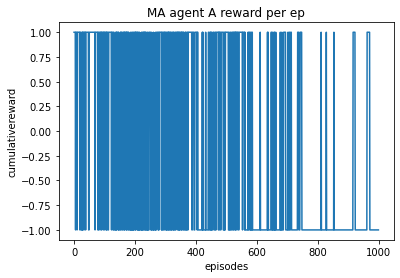

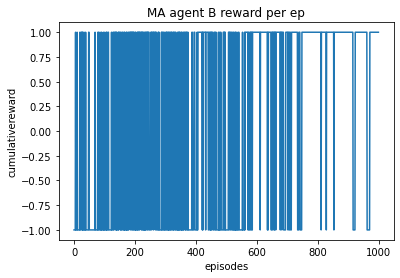

<function matplotlib.pyplot.show>

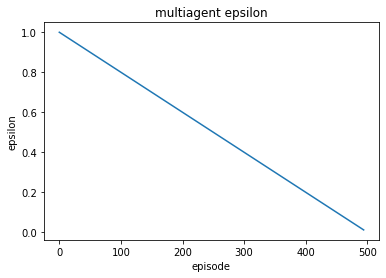

In [ ]:
# def multiDQN():
env = MultiAgentEnv()
env.reset()
agentA = MTDQNAgent(env)
agentB = MTDQNAgent(env)
decay = 0.995
EPSILON = 1
MTDQNplotA=[]
MTDQNplotB=[]
n_games = 1000
k=0
for i in range(n_games):
  env.reset()
  done = False
  culRewardA = 0
  culRewardB = 0
  while not done:
    k+=1
    s = [env.agentA_pos[0], env.agentA_pos[1], env.agentB_pos[0], env.agentB_pos[1]]
    actionA = agentA.step(s)
    actionB = agentB.step(s)
    obs, reward, done, info = env.step(actionA, actionB)
    s_ = [obs[0][0], obs[0][1], obs[1][0], obs[1][1]]
    agentA.store_mem(s, actionA, reward[0], s_, done)
    agentB.store_mem(s, actionB, reward[1], s_,done)
    if k%5 == 1:
      agentA.train()
      agentB.train()
    culRewardA+=reward[0]
    culRewardB+=reward[1]
  EPSILON = EPSILON*decay if EPSILON > 0.01 else 0.01
  # EPSILON = EPSILON - 2/n_games if EPSILON > 0.01 else 0.01
  MTDQNplotA.append(culRewardA)
  MTDQNplotB.append(culRewardB)  

MultiDQNGreedyA= []
MultiDQNGreedyB = []
for i in range(5):
  env.reset()
  done = False
  culRewardA = 0
  culRewardB = 0
  while not done:
    s = [env.agentA_pos[0], env.agentA_pos[1], env.agentB_pos[0], env.agentB_pos[1]]
    actionA = agentA.step(s)
    actionB = agentB.step(s)
    obs, reward, done, info = env.step(actionA, actionB)
    s_ = [obs[0][0], obs[0][1], obs[1][0], obs[1][1]]
    culRewardA+=reward[0]
    culRewardB+=reward[1]
  MultiDQNGreedyA.append(culRewardA)
  MultiDQNGreedyB.append(culRewardB)  

plt.plot(MTDQNplotA)
plt.title('MA agent A reward per ep')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()
plt.plot(MTDQNplotB)
plt.title('MA agent B reward per ep')
plt.xlabel('episodes')
plt.ylabel('cumulativereward')
plt.show()

multiEpsilon=[]
EPSILON = 1

while EPSILON>=0.01:
  multiEpsilon.append(EPSILON)
  EPSILON = EPSILON - 2/n_games
  
plt.plot(multiEpsilon)
plt.title('multiagent epsilon')
plt.xlabel('episode')
plt.ylabel('epsilon')
plt.show

#Multi agent Double DQN

In [ ]:
# def MultiDDQN():
EPSILON = 1
env = MultiAgentEnv()
agentA = MTDDQNAgent(env)
agentB = MTDDQNAgent(env)
decay = 0.995
EPSILON = 1
MTDDQNplotA=[]
MTDDQNplotB=[]
n_games = 1000
k = 0
for i in range(n_games):
  env.reset()
  done = False
  culRewardA = 0
  culRewardB = 0
  while not done:
    k+=1
    s = [env.agentA_pos[0], env.agentA_pos[1], env.agentB_pos[0], env.agentB_pos[1]]
    actionA = agentA.step(s)
    actionB = agentB.step(s)
    obs, reward, done, info = env.step(actionA, actionB)
    s_ = [obs[0][0], obs[0][1], obs[1][0], obs[1][1]]
    if k%5 == 1:
      agentA.train()
      agentB.train()
    culRewardA+=reward[0]
    culRewardB+=reward[1]
    # if done:
    #   print(obs, env.timestep)
  EPSILON = EPSILON - 2/n_games if EPSILON > 0.01 else 0.01
  # if EPSILON>0.01:
  #   EPSILON*=decay
  MTDDQNplotA.append(culRewardA)
  MTDDQNplotB.append(culRewardB)  


MultiDDQNGreedyA= []
MultiDDQNGreedyB = []
for i in range(5):
  env.reset()
  done = False
  culRewardA = 0
  culRewardB = 0
  while not done:
    s = [env.agentA_pos[0], env.agentA_pos[1], env.agentB_pos[0], env.agentB_pos[1]]
    actionA = agentA.step(s)
    actionB = agentB.step(s)
    obs, reward, done, info = env.step(actionA, actionB)
    agentA.store_mem(s, actionA, reward[0], s_)
    agentB.store_mem(s, actionB, reward[1], s_)
    culRewardA+=reward[0]
    culRewardB+=reward[1]
  MultiDDQNGreedyA.append(culRewardA)
  MultiDDQNGreedyB.append(culRewardB)  


# plt.plot(MTDDQNplotA)
# plt.title('multiagent agent A rewards')
# plt.xlabel('episodes')
# plt.ylabel('cumulativereward')
# plt.show()
# plt.plot(MTDDQNplotB)
# plt.title('multiagent agent B rewards')
# plt.xlabel('episodes')
# plt.ylabel('cumulativereward')
# plt.show()
# plt.plot(MTDQNplotA, label = 'DQN agent A')
# plt.plot(MTDDQNplotA, label = 'DDQN agent A')
# plt.title('multiagent reward comparison')
# plt.xlabel('episodes')
# plt.ylabel('cumulativereward')
# plt.show()


# Main Fcuntion: Graphs (run all cells before running following cell)

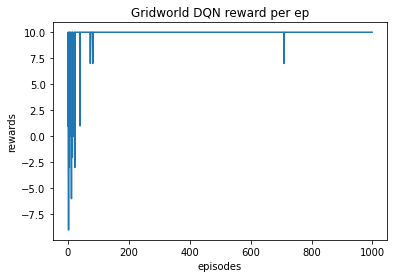

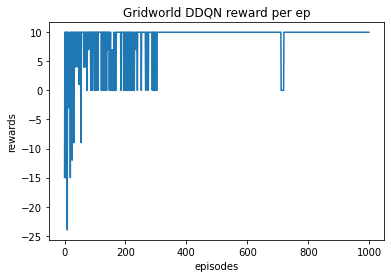

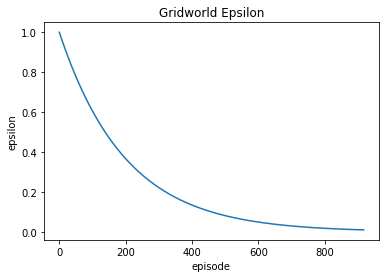

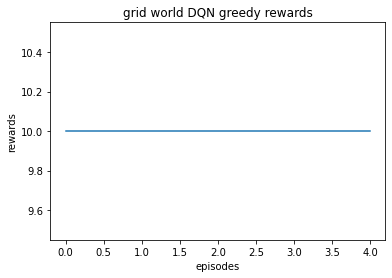

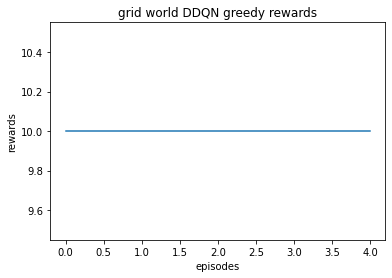

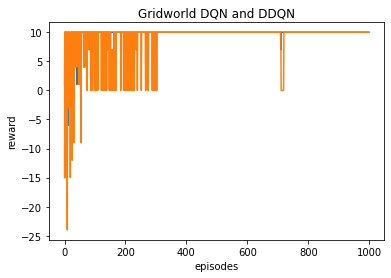

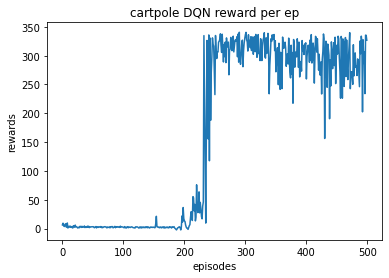

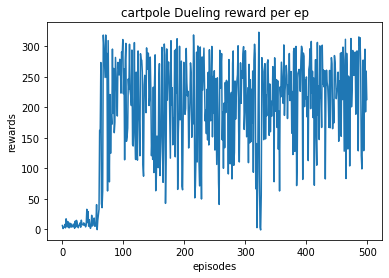

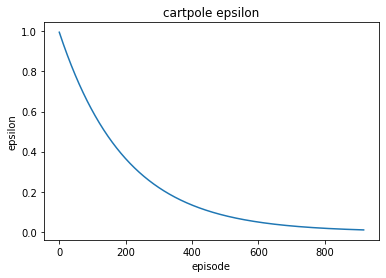

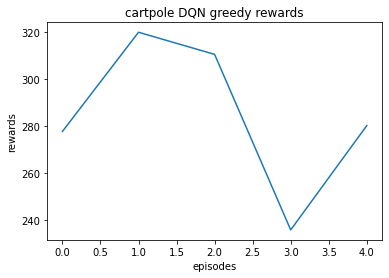

5


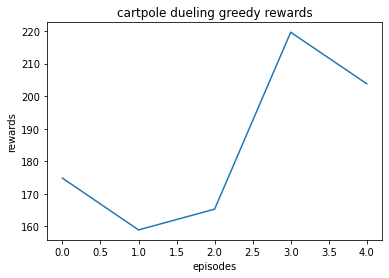

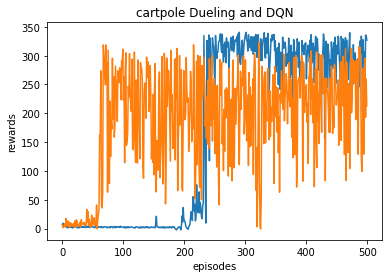

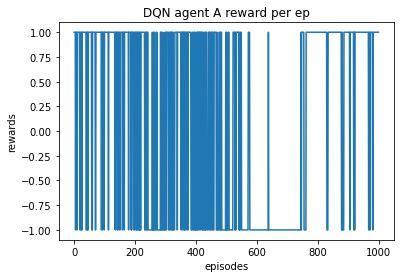

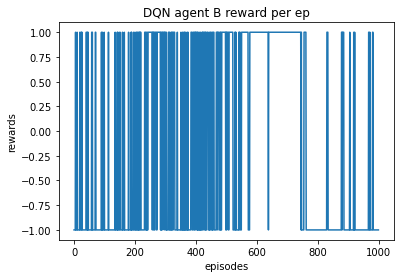

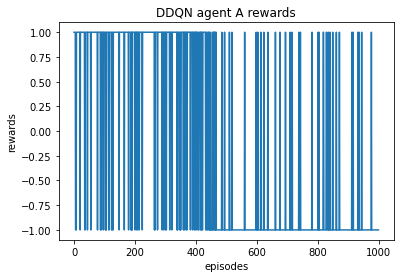

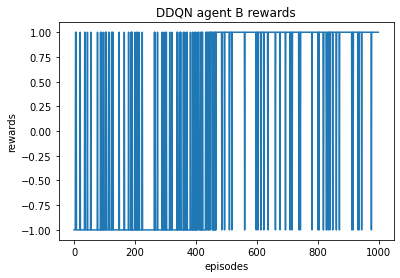

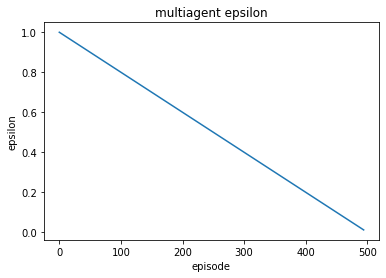

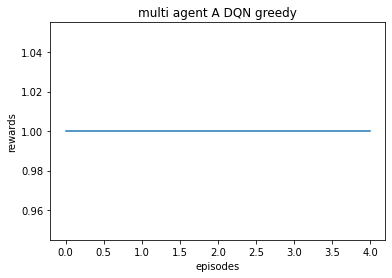

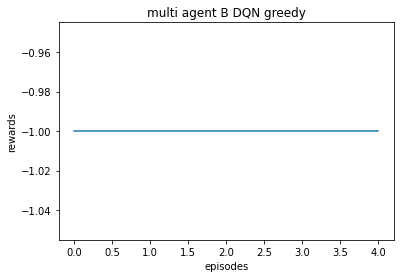

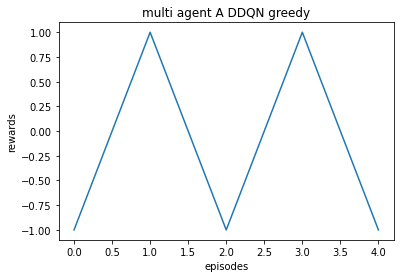

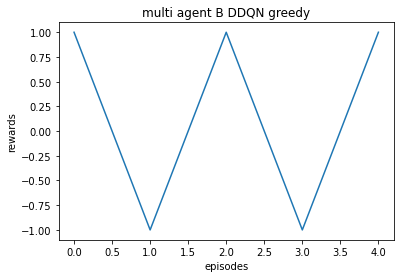

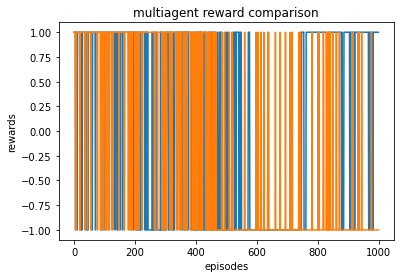

In [ ]:

# grid world dqn
plt.plot(gridDQNplot)
plt.title('Gridworld DQN reward per ep')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
#grid world ddqn
plt.plot(gridDDQNplot)
plt.title('Gridworld DDQN reward per ep')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
#grid world epsilon
gridepsilonplot = []
EPSILON = 1
E_DECAY = 0.995
while EPSILON>=0.01:
  gridepsilonplot.append(EPSILON)
  EPSILON*=E_DECAY
plt.plot(gridepsilonplot)
plt.title('Gridworld Epsilon')
plt.xlabel('episode')
plt.ylabel('epsilon')
plt.show()

#gridworld greedy rewards
plt.plot(gridDQNgreedy)
plt.title('grid world DQN greedy rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
plt.plot(gridDDQNgreedy)
plt.title('grid world DDQN greedy rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

#grid world reward comparison
plt.plot(gridDQNplot)
plt.plot(gridDDQNplot)
plt.title('Gridworld DQN and DDQN')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.show()


#cartpole dqn
plt.plot(cartDQNplot)
# print(len(cartDQNplot))
# print(cartDQNplot)
plt.title('cartpole DQN reward per ep')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

#cartpole dueling dqn
plt.plot(cartDDQNplot)
plt.title('cartpole Dueling reward per ep')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

#cartpole epsilon
cartEpsilon=[]
EPSILON = 1
E_DECAY = 0.995
while EPSILON>=0.01:
  EPSILON*=E_DECAY
  cartEpsilon.append(EPSILON)
plt.plot(cartEpsilon)
plt.title('cartpole epsilon')
plt.xlabel('episode')
plt.ylabel('epsilon')
plt.show()

#cartpole greedy rewards
plt.plot(cartDQNgreedy)
plt.title('cartpole DQN greedy rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
plt.plot(cartDDQNgreedy)
print(len(cartDDQNgreedy))
plt.title('cartpole dueling greedy rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

#cartpole comparison
plt.plot(cartDQNplot)
plt.plot(cartDDQNplot)
plt.title('cartpole Dueling and DQN')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()


#multiagent dqn
#agent A
plt.plot(MTDQNplotA)
plt.title('DQN agent A reward per ep')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
# agent B
plt.plot(MTDQNplotB)
plt.title('DQN agent B reward per ep')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

#multiagent DDQN
#agent A
plt.plot(MTDDQNplotA)
plt.title('DDQN agent A rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
#agent B
plt.plot(MTDDQNplotB)
plt.title('DDQN agent B rewards')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()


# multiagent Epsilon
multiEpsilon=[]
EPSILON = 1
while EPSILON>=0.01:
  multiEpsilon.append(EPSILON)
  EPSILON = EPSILON - 2/n_games
plt.plot(multiEpsilon)
plt.title('multiagent epsilon')
plt.xlabel('episode')
plt.ylabel('epsilon')
plt.show()

# multiagent dqn greedy
plt.plot(MultiDQNGreedyA)
plt.title('multi agent A DQN greedy')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
plt.plot(MultiDQNGreedyB)
plt.title('multi agent B DQN greedy')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()


# multiagent ddqn greedy
plt.plot(MultiDDQNGreedyA)
plt.title('multi agent A DDQN greedy')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
plt.plot(MultiDDQNGreedyB)
plt.title('multi agent B DDQN greedy')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()

#multiagent agent A reward comparison
plt.plot(MTDQNplotA, label = 'DQN agent A')
plt.plot(MTDDQNplotA, label = 'DDQN agent A')
plt.title('multiagent reward comparison')
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.show()
